In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras import layers
import os
import cv2
#Face generation using anime dataset


In [24]:
#Variable definitions
HEIGHT=64
WIDTH=64
LEARNING_RATE=1e-3
CHANNELS=3
EPOCHS=1
BATCH_SIZE=3
NOISE_DIM=150


In [25]:
print(len(tf.config.list_physical_devices("GPU")))

0


In [26]:

path ='/Users/mitchellculligan/Desktop/SFWRTECH 4NN3/FaceRecognition/images'
print(len(os.listdir(path)))
#load data from directory exclusivley filled with images
def loadData(path):
    dataset=[]
    for img in os.listdir(path):
        img_array= cv2.imread(os.path.join(path,img))
        new_array=cv2.resize(img_array,(HEIGHT,WIDTH))
        dataset.append(new_array)
        
    return np.array(dataset)


data=loadData(path)

63565


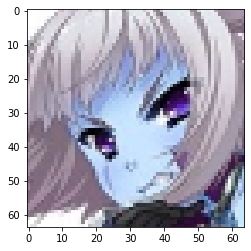

In [27]:
plt.imshow(data[4])

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150)]             0         
                                                                 
 normalization_4 (Normaliza  (None, 150)               301       
 tion)                                                           
                                                                 
 generator_layer_1 (Dense)   (None, 4096)              618496    
                                                                 
 batch_normalization_8 (Bat  (None, 4096)              16384     
 chNormalization)                                                
                                                                 
 generator_reshape_layer (R  (None, 64, 64, 1)         0         
 eshape)                                                         
                                                           

tf.Tensor(
[[[0.49969158 0.50081307 0.50083625]
  [0.4996419  0.50044316 0.500788  ]
  [0.49992037 0.49949604 0.50050414]
  ...
  [0.5002432  0.50035125 0.5007559 ]
  [0.5001211  0.4984973  0.50042737]
  [0.5004586  0.4996856  0.49983194]]

 [[0.49889186 0.5007156  0.5002962 ]
  [0.49956787 0.4994648  0.5001844 ]
  [0.5003948  0.49819973 0.49973685]
  ...
  [0.50015473 0.4991126  0.49840385]
  [0.50256    0.49859875 0.49871925]
  [0.50069577 0.49849766 0.5000022 ]]

 [[0.49780455 0.5004348  0.50005305]
  [0.49982125 0.49779582 0.49990696]
  [0.49964944 0.49867043 0.5000301 ]
  ...
  [0.500102   0.49603063 0.49929175]
  [0.501765   0.49652722 0.500154  ]
  [0.50122195 0.4987163  0.49962038]]

 ...

 [[0.49985665 0.49963695 0.4992525 ]
  [0.4988636  0.5005911  0.49899396]
  [0.49974957 0.49983808 0.49553347]
  ...
  [0.49992195 0.5000997  0.49886   ]
  [0.5009436  0.49970683 0.4986947 ]
  [0.49833414 0.49968788 0.50066805]]

 [[0.4989159  0.5009265  0.50016665]
  [0.49784717 0.49841845 0

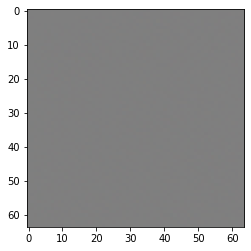

In [28]:
#Create Generator model
def createGenerator(height,width,channels,noise_dim):
#takes in 2 numbers mean and variance(Or supposedly)
    gInputs=layers.Input(shape=(noise_dim,))
    norm=layers.Normalization()(gInputs)
    h0=layers.Dense(height*width,activation='relu',name='generator_layer_1',kernel_initializer='glorot_normal')(norm)
    norm=layers.BatchNormalization()(h0)
    gReshape=layers.Reshape((height,width,1),name='generator_reshape_layer')(norm)#Reshaping to fit the conv layers
    conv0=layers.Conv2DTranspose(4,3,activation='relu',padding='same',kernel_initializer='glorot_normal',name='conv_layer1_generator')(gReshape)
    conv1=layers.Conv2DTranspose(6,4,activation='relu',name='conv_layer2_generator',padding='same',kernel_initializer='glorot_normal')(conv0)
    norm=layers.BatchNormalization()(conv1)
    conv2=layers.Conv2DTranspose(16,5,padding='same',activation='relu',name='conv_layer3_generator',kernel_initializer='glorot_normal')(norm)
    norm=layers.BatchNormalization()(conv2)
    conv3=layers.Conv2DTranspose(12,4,padding='same',activation='relu',name='conv_layer4_generator',kernel_initializer='glorot_normal')(norm)
    drop_out=layers.Dropout(0.4)(conv3)
    conv4=layers.Conv2DTranspose(channels,3,padding='same',activation='sigmoid',kernel_initializer='glorot_normal', name='conv_layer5_generator')(drop_out)
 

    generator=keras.Model(inputs=gInputs,outputs=conv4)

    return generator


generator=createGenerator(HEIGHT,WIDTH,CHANNELS,NOISE_DIM)

generator.summary()

generator.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),loss=keras.losses.BinaryCrossentropy(from_logits=False))


mean_var_const=tf.random.normal([2,NOISE_DIM])

image=generator(mean_var_const)
print(image[0])
plt.imshow(image[0])

In [29]:
#make Discriminator model

def createDiscriminator(height,width,channels):

    input=layers.Input(shape=(height,width,channels),name='discriminator_input')
    norm=layers.Normalization()(input)
    reshape=layers.Reshape((height,width,channels))(norm)
    conv0=layers.Conv2D(5,3,activation='relu',kernel_initializer='glorot_normal',padding='same',name='discriminator_conv1')(reshape)
    conv1=layers.Conv2D(6,3,activation='relu',padding='same',kernel_initializer='glorot_normal',name='discriminator_conv2')(conv0)
    pool0=layers.AveragePooling2D((2,2))(conv1)
    conv2=layers.Conv2D(12,4,padding='same',activation='relu',name='discriminator_conv3',kernel_initializer='glorot_normal')(pool0)
    pool1=layers.AveragePooling2D((2,2))(conv2)
    conv2=layers.Conv2D(12,4,padding='same',activation='relu',name='discriminator_conv4',kernel_initializer='glorot_normal')(pool1)
    pool2=layers.AveragePooling2D((2,2))(conv2)
    conv3=layers.Conv2D(24,3,padding='same',activation='relu',name='discriminator_conv5',kernel_initializer='glorot_normal')(pool2)
    flat_layer=layers.Flatten()(conv3)
    batch_norm=layers.BatchNormalization()(flat_layer)
    fc1=layers.Dense(24,activation='sigmoid',kernel_initializer='glorot_normal',name='first_connected_layer_discriminator')(batch_norm)
    drop_out=layers.Dropout(0.2)(fc1)
    output=layers.Dense(1,activation='sigmoid',name='output_discriminator',kernel_initializer='glorot_normal')(drop_out)
    #outputs the probability of if the given image is real or not

    discriminator=keras.Model(inputs=input,outputs=output)
    return discriminator

discriminator=createDiscriminator(HEIGHT,WIDTH,CHANNELS)


discriminator.summary()

discriminator.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),loss=keras.losses.BinaryCrossentropy(from_logits=False))

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 discriminator_input (Input  [(None, 64, 64, 3)]       0         
 Layer)                                                          
                                                                 
 normalization_5 (Normaliza  (None, 64, 64, 3)         7         
 tion)                                                           
                                                                 
 reshape_2 (Reshape)         (None, 64, 64, 3)         0         
                                                                 
 discriminator_conv1 (Conv2  (None, 64, 64, 5)         140       
 D)                                                              
                                                                 
 discriminator_conv2 (Conv2  (None, 64, 64, 6)         276       
 D)                                                        

In [30]:


@tf.function
def trainStep(discriminator,generator,data, batchSize,noiseDims):
    noise=tf.random.normal([batchSize,noiseDims])
    disc_loss=None
    generator_loss=None
    with tf.GradientTape() as d_tape,tf.GradientTape() as g_tape:
        #generate fake images from noise
        fake_images=generator(noise,training=True)
        #generate the discriminator loss on real and fake images
        real_outputs=discriminator(data,training=True)
        fake_outputs=discriminator(fake_images,training=True)
        real_loss=discriminator.loss(tf.ones_like(real_outputs),real_outputs)
        fake_loss=discriminator.loss(tf.zeros_like(fake_outputs),fake_outputs)
       
        disc_loss=fake_loss+real_loss

       
        #we hope that the discriminator got all of the images wrong
        generator_loss=generator.loss(tf.ones_like(fake_outputs),fake_outputs)
        #compute gradients
        d_grads=d_tape.gradient(disc_loss,discriminator.trainable_variables)
        g_grads=g_tape.gradient(generator_loss,generator.trainable_variables)

        #apply gradients
        discriminator.optimizer.apply_gradients(zip(d_grads,discriminator.trainable_variables))
        generator.optimizer.apply_gradients(zip(g_grads,generator.trainable_variables))

    return generator_loss,disc_loss




def trainLoop(discriminator,generator,dataSet,batchSize,epochs,noiseDim):
    d_loss=[]
    g_loss=[]
    for epoch in range(epochs):
        for step,data in enumerate(dataSet):
            gen_loss,dis_loss=trainStep(discriminator,generator,data,batchSize,noiseDim)
            if step%1000==0:
                print(f"Step: {step}")
                g_loss.append(gen_loss)
                d_loss.append(dis_loss)
                print(f"Epoch: {epoch+1}\nGen Loss: {g_loss[-1]}\nDiscriminator Loss: {d_loss[-1]}")
        g_loss.append(gen_loss)
        d_loss.append(dis_loss)
        print(f"Epoch: {epoch+1}\nGen Loss: {g_loss[-1]}\nDiscriminator Loss: {d_loss[-1]}")
    

    return g_loss,d_loss



In [31]:

train_dataset=tf.data.Dataset.from_tensor_slices((data))
train_dataset=train_dataset.shuffle(buffer_size=20).batch(BATCH_SIZE)



In [32]:
#call training loop func

gen_loss,dis_loss=trainLoop(discriminator,generator,train_dataset,BATCH_SIZE,EPOCHS,NOISE_DIM)

Step: 0
Epoch: 1
Gen Loss: 0.6686801910400391
Discriminator Loss: 1.4460630416870117
Step: 1000
Epoch: 1
Gen Loss: 3.6628458499908447
Discriminator Loss: 0.05524453520774841
Step: 2000
Epoch: 1
Gen Loss: 3.14685320854187
Discriminator Loss: 0.06580840796232224
Step: 3000
Epoch: 1
Gen Loss: 3.1001691818237305
Discriminator Loss: 0.06776063144207001
Step: 4000
Epoch: 1
Gen Loss: 4.043191909790039
Discriminator Loss: 0.04181478172540665
Step: 5000
Epoch: 1
Gen Loss: 5.522912979125977
Discriminator Loss: 0.012905459851026535
Step: 6000
Epoch: 1
Gen Loss: 4.298157215118408
Discriminator Loss: 0.017759857699275017
Step: 7000
Epoch: 1
Gen Loss: 5.182973384857178
Discriminator Loss: 0.008272623643279076
Step: 8000
Epoch: 1
Gen Loss: 5.011406421661377
Discriminator Loss: 0.011892888695001602
Step: 9000
Epoch: 1
Gen Loss: 5.72288703918457
Discriminator Loss: 0.003362637013196945
Step: 10000
Epoch: 1
Gen Loss: 3.0434494018554688
Discriminator Loss: 0.05707657337188721
Step: 11000
Epoch: 1
Gen Los

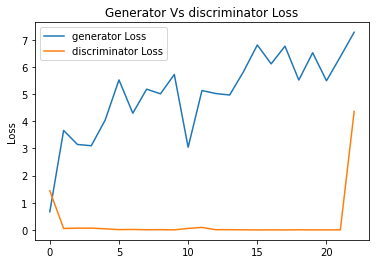

In [33]:
plt.plot(gen_loss,label='generator Loss')
plt.plot(dis_loss,label='discriminator Loss')
plt.ylabel('Loss')
plt.title("Generator Vs discriminator Loss")
plt.legend()
plt.show()

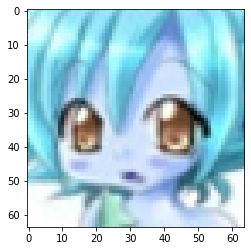

In [34]:

index=12



plt.imshow(data[index])


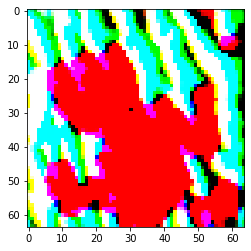

In [38]:
noise=tf.random.normal([1,NOISE_DIM])
image=generator(noise)
plt.imshow(image[0])